# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
import sys
sys.setrecursionlimit(10000)

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

cuda


### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [3]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec

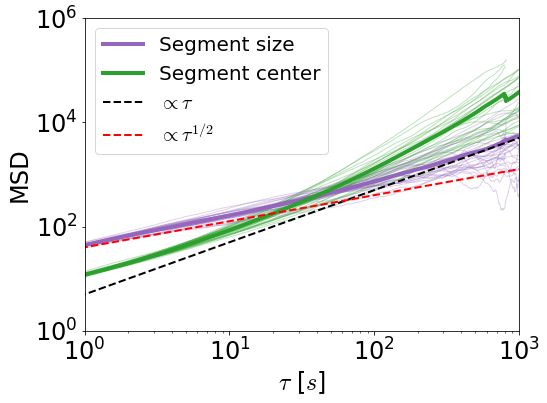

In [62]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['dissolve']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
            
        msd_sep_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(seg_center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.plot(time_arr, msd_center_list[-1], color='tab:green', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Segment size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Segment center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_xlim(1, 1000)
_ = axarr.set_ylim(1,1e6)

fig.tight_layout()
fig.savefig("Figure4/edge_sep_msd_dissolve.png", dpi=600,bbox_inches='tight')
        

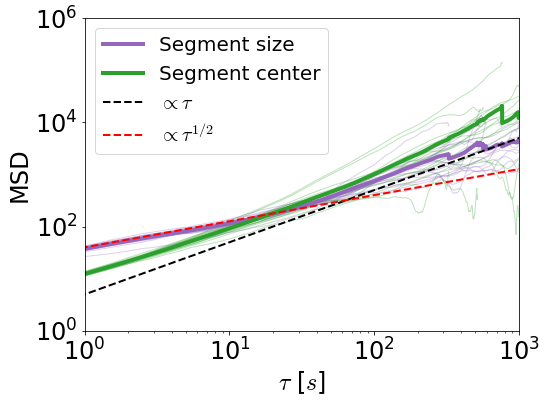

In [61]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['merge']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
            
        msd_sep_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(seg_center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.plot(time_arr, msd_center_list[-1], color='tab:green', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Segment size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Segment center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_xlim(1, 1000)
_ = axarr.set_ylim(1,1e6)

fig.tight_layout()
fig.savefig("Figure4/edge_sep_msd_dissolve.png", dpi=600,bbox_inches='tight')
        

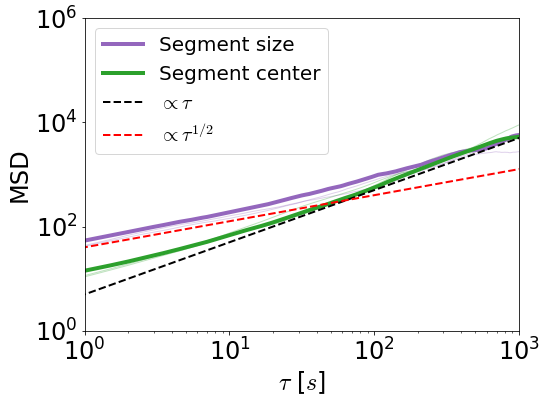

In [60]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
            
        msd_sep_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(seg_center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.plot(time_arr, msd_center_list[-1], color='tab:green', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Segment size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Segment center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_xlim(1, 1000)
_ = axarr.set_ylim(1,1e6)

fig.tight_layout()
fig.savefig("Figure4/edge_sep_msd_dissolve.png", dpi=600,bbox_inches='tight')
        

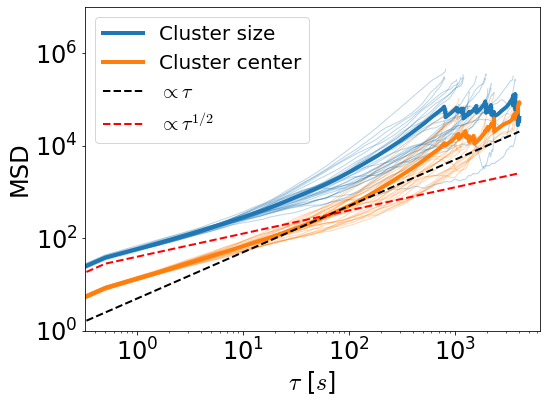

In [50]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['dissolve']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        center = (dset_0[:,2] + dset_0[:,1])*.5
        size = (dset_0[:,2] - dset_0[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

        # center = (dset_1[:,2] + dset_1[:,1])*.5
        # size = (dset_1[:,2] - dset_1[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='C0', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='C1', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

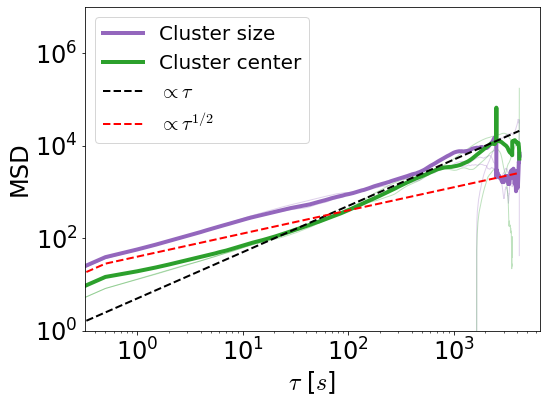

In [63]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        center = (dset_0[:,2] + dset_0[:,1])*.5
        size = (dset_0[:,2] - dset_0[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:green', **plot_params)

        # center = (dset_1[:,2] + dset_1[:,1])*.5
        # size = (dset_1[:,2] - dset_1[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

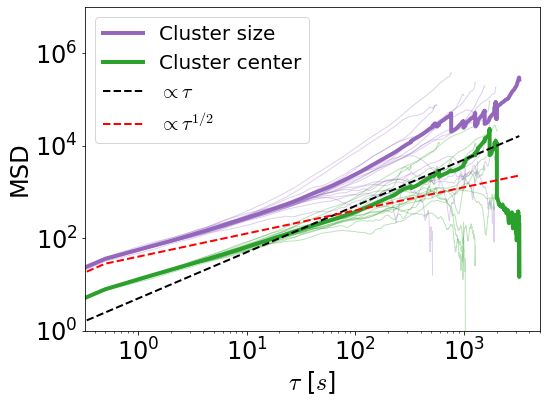

In [64]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['merge']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        center = (dset_0[:,2] + dset_0[:,1])*.5
        size = (dset_0[:,2] - dset_0[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:green', **plot_params)

        # center = (dset_1[:,2] + dset_1[:,1])*.5
        # size = (dset_1[:,2] - dset_1[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

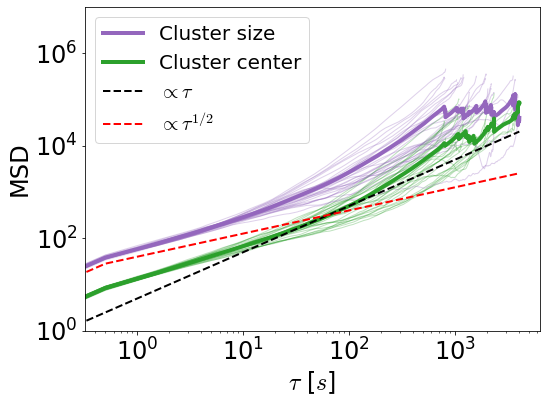

In [65]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['dissolve']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        center = (dset_0[:,2] + dset_0[:,1])*.5
        size = (dset_0[:,2] - dset_0[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:green', **plot_params)

        # center = (dset_1[:,2] + dset_1[:,1])*.5
        # size = (dset_1[:,2] - dset_1[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 5*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

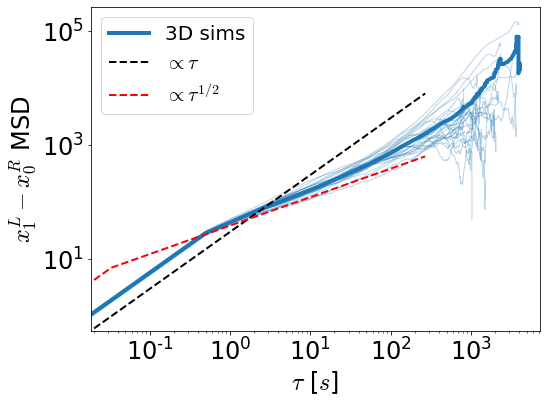

In [ ]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['dissolve']

    msd_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            
        msd_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_list[-1], color='tab:blue', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_size_arr = mean_of_arrays(msd_list)
    _ = axarr.loglog(max_time_arr, avg_size_arr, color='C0', linewidth=4, label="3D sims")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



# data_path =  next(ceph_path.glob('DynCondPaper/minimal_cond_runs/24-03-21_Renger1600_slice9.7.1_sep50-450_L3-9um/simulations/lsep100_L5/*.h5'))
# with h5py.File(data_path, 'r') as h5_data:
#     params = yaml.safe_load(h5_data.attrs['params'])

#     nu = params['kinetics']['nu']
#     gamma = params['kinetics']['gamma']
#     alpha = params['kinetics']['alpha']
#     kappa = params['kinetics']['kappa']
#     L = params['kinetics']['L']
#     b = params['kinetics']['bd']
#     Lc = params['n_beads'] * b
#     beta = 1./.00411
#     # t_max = params['t_max']
#     ko = 15

#     time_arr_list = []
#     com_arr_list = []
#     size_arr_list = []

#     edge_diff_msd_list = []
#     time_arr_list = []
#     max_time_arr = np.array([])
#     for group in h5_data.keys():
#         if 'run' not in group:
#             continue
#         group_data = h5_data[group]

#         last_sizes = group_data['sizes'][0, -1]
#         if not(last_sizes[0] == 0 or last_sizes[1] == 0):
#             continue
#         time_arr = group_data['times'][...]

#         state_arr = group_data['states'][...]
#         l_diff = state_arr[:,1,0] - state_arr[:,0,1] 
#         reg_time_arr, reg_l_diff = calc_regular_interval_kmc_array(time_arr, l_diff, time_arr[-1], 15)
#         if len(reg_time_arr) > len(max_time_arr):
#             max_time_arr = reg_time_arr
#         edge_diff_msd_list.append(condensate_msd(reg_l_diff[np.newaxis,:].astype('float'), device=device).cpu()[0])
#         # _ = axarr.plot(reg_time_arr/ko, edge_diff_msd_list[-1], color='C0')
#         time_arr_list.append(reg_time_arr)

    # avg_size_arr = mean_of_arrays(edge_diff_msd_list)
    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    _ = axarr.loglog(max_time_arr/ko, 2*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr/ko, 10*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('$x^L_1 - x^R_0$ MSD') 
_ = axarr.legend()

fig.tight_layout()
fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

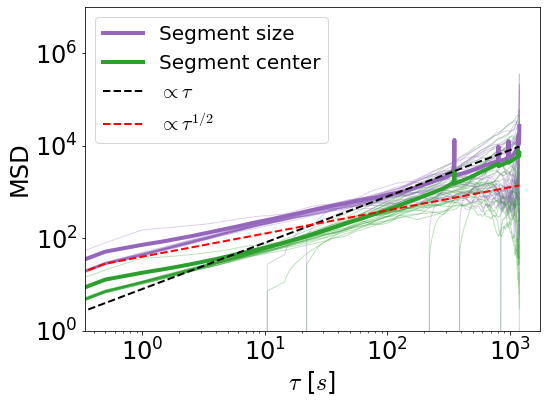

In [66]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data_sep400.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
            
        msd_sep_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(seg_center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.plot(time_arr, msd_center_list[-1], color='tab:green', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Segment size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Segment center")

    _ = axarr.loglog(max_time_arr, 8*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

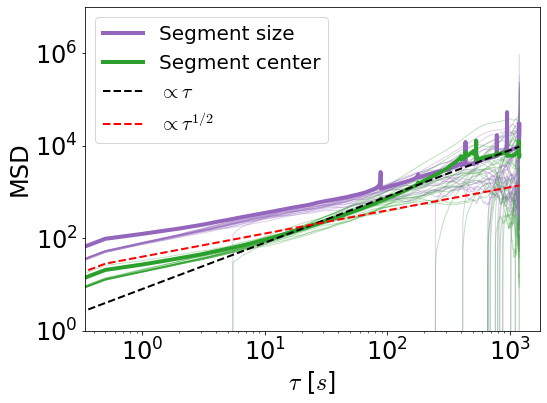

In [67]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data_sep400_kod300.h5", 'r') as h5_graph:
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        if dset_1[0,2] > dset_0[0,2]: # Cond 1 is to the right of cond 0
            xr = dset_0[:,2] + .5*dset_0[:,1]
            xl = dset_1[:,2] - .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
        else:
            xl = dset_0[:,2] - .5*dset_0[:,1]
            xr = dset_1[:,2] + .5*dset_1[:,1]
            edge_sep = xl - xr
            seg_center = (xl + xr)/2
            
        msd_sep_list.append(condensate_msd(edge_sep[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(seg_center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.plot(time_arr, msd_sep_list[-1], color='tab:purple', **plot_params)
        _ = axarr.plot(time_arr, msd_center_list[-1], color='tab:green', **plot_params)
        # msd_list[-1].shape
        # time_arr_list.append(time_arr)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='tab:purple', linewidth=4, label="Segment size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='tab:green', linewidth=4, label="Segment center")

    _ = axarr.loglog(max_time_arr, 8*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

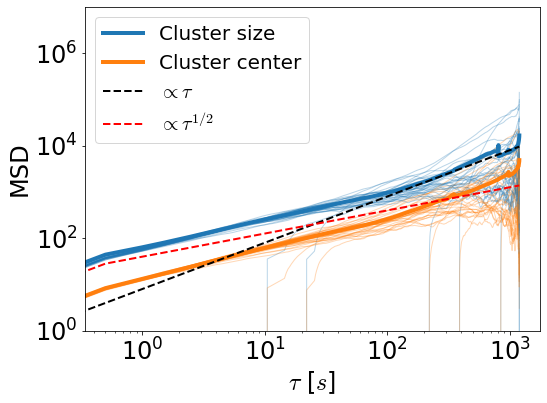

In [43]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data_sep400.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        center = (dset_0[:,2] + dset_0[:,1])*.5
        size = (dset_0[:,2] - dset_0[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

        # center = (dset_1[:,2] + dset_1[:,1])*.5
        # size = (dset_1[:,2] - dset_1[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='C0', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='C1', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 8*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        

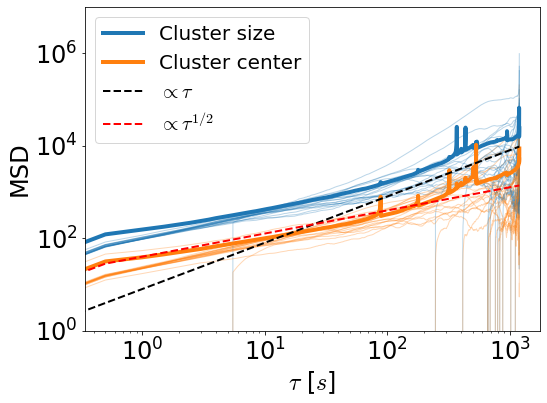

In [45]:
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}
fig, axarr = plt.subplots(1,1, figsize=(8, 6))

with h5py.File("Figure4/fig4_cluster_data_sep400_kod300.h5", 'r') as h5_graph:
    # List all groups
    dissolve_grp = h5_graph['nothing']

    msd_sep_list = []
    msd_center_list = []
    time_arr_list = []
    max_time_arr = []
    for i in range(1, 49):
        if not f's{i}_0' in dissolve_grp: 
            continue

        sort_indices = np.argsort(dissolve_grp[f's{i}_0'][:,0])
        dset_0 = (dissolve_grp[f's{i}_0'][...])[sort_indices,:]

        sort_indices = np.argsort(dissolve_grp[f's{i}_1'][:,0])
        dset_1 = (dissolve_grp[f's{i}_1'][...])[sort_indices,:]

        time_arr = dset_0[:,0] if len(dset_0[:,0]) < len(dset_1[:,0]) else dset_1[:,0]
        dset_0 = dset_0[:len(time_arr)]
        dset_1 = dset_1[:len(time_arr)]

        if len(time_arr) > len(max_time_arr):
            max_time_arr = time_arr
        # center = (dset_0[:,2] + dset_0[:,1])*.5
        # size = (dset_0[:,2] - dset_0[:,1])
        # msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        # _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        # _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

        center = (dset_1[:,2] + dset_1[:,1])*.5
        size = (dset_1[:,2] - dset_1[:,1])
        msd_sep_list.append(condensate_msd(size[np.newaxis,:].astype('float'), device=device).cpu()[0])
        msd_center_list.append(condensate_msd(center[np.newaxis,:].astype('float'), device=device).cpu()[0])
        _ = axarr.loglog(time_arr, msd_sep_list[-1], color='tab:blue', **plot_params)
        _ = axarr.loglog(time_arr, msd_center_list[-1], color='tab:orange', **plot_params)

    avg_sep_size_arr = mean_of_arrays(msd_sep_list)
    avg_center_size_arr = mean_of_arrays(msd_center_list)
    _ = axarr.loglog(max_time_arr, avg_sep_size_arr, color='C0', linewidth=4, label="Cluster size")
    _ = axarr.loglog(max_time_arr, avg_center_size_arr, color='C1', linewidth=4, label="Cluster center")
    # _ = axarr.loglog(max_time_arr, 30*max_time_arr, color='k', linewidth=2, linestyle='--', label)



    # _ = axarr.loglog(max_time_arr/ko, avg_size_arr, color='C1', linewidth=4, label=r'FP sims')
    # _ = axarr.loglog(max_time_arr, .1*np.power(max_time_arr,2), color='g', linestyle='--', label=r'$\propto \tau^{2}$')
    _ = axarr.loglog(max_time_arr, 8*max_time_arr, color='k', linestyle='--', label=r'$\propto \tau$')
    _ = axarr.loglog(max_time_arr, 40*np.sqrt(max_time_arr), color='r', linestyle='--', label=r'$\propto \tau^{1/2}$')


_ = axarr.set_xlabel(r'$\tau$ [$s$]')
_ = axarr.set_ylabel('MSD') 
_ = axarr.legend()
_ = axarr.set_ylim(1,1e7)

fig.tight_layout()
# fig.savefig("Figure4/edge_sep_msd.png", dpi=600,bbox_inches='tight')
        